In [1]:
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import heapq
import pandas as pd

C:\Users\assas\AppData\Local\Temp\ipykernel_5144\846880267.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
img = cv.imread('../../../data/tibia_fibula_fracture/fracture/0.png')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
dns = cv.fastNlMeansDenoising(gray, None, 7, 21)
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(dns)
thresh = cv.threshold(cl1,120,255,cv.THRESH_BINARY)[1]

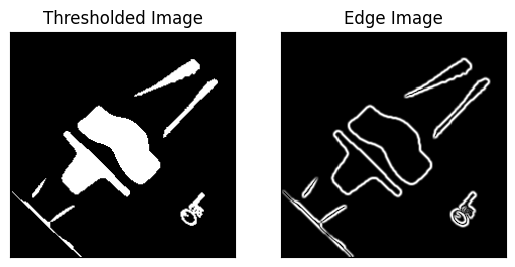

In [3]:
sobelx = cv.Sobel(thresh, cv.CV_64F, 1, 0, ksize=5)
sobely = cv.Sobel(thresh, cv.CV_64F, 0, 1, ksize=5)
edge_img = cv.sqrt(cv.add(cv.pow(sobelx, 2.0), cv.pow(sobely, 2.0)))
edge_img = cv.normalize(edge_img, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
plt.subplot(121),plt.imshow(thresh,cmap = 'gray')
plt.title('Thresholded Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edge_img, cmap = 'gray', interpolation='none')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

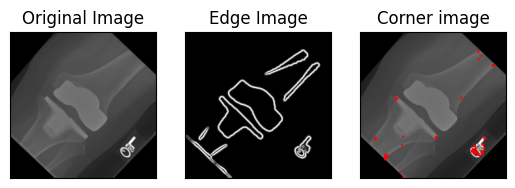

In [4]:
corners = cv.cornerHarris(edge_img, 2, 3, 0.04)
#result is dilated for marking the corners, not important
corners = cv.dilate(corners, None)
# Threshold for an optimal value, it may vary depending on the image.
result = img.copy()
result[corners > 0.1 * corners.max()] = [0, 0, 255]
cdst = cv.cvtColor(result, cv.COLOR_BGR2RGB)
plt.subplot(1, 3, 1),plt.imshow(img, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 3, 2),plt.imshow(edge_img, cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 3, 3),plt.imshow(cdst)
plt.title('Corner image'), plt.xticks([]), plt.yticks([])
plt.show()

In [5]:
def image_processing(image_dir):
    img = cv.imread(image_dir)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    dns = cv.fastNlMeansDenoising(gray, None, 7, 21)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(dns)
    threshold = cv.threshold(cl1,120,255,cv.THRESH_BINARY)[1]
    sobelx = cv.Sobel(threshold, cv.CV_64F, 1, 0, ksize=5)
    sobely = cv.Sobel(threshold, cv.CV_64F, 0, 1, ksize=5)
    edge_img = cv.sqrt(cv.add(cv.pow(sobelx, 2.0), cv.pow(sobely, 2.0)))
    edge_img = cv.normalize(edge_img, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    return edge_img

In [6]:
def get_features(sobel_edges, corners):
    if corners is not None:
        area = cv.countNonZero(sobel_edges) / sobel_edges.shape[0]
        nm_crn = np.sum(corners > 0.1 * corners.max())
        crn_rto = nm_crn / sobel_edges.shape[0]
        return [area, nm_crn, crn_rto]
    else:
        return None

In [7]:
def sobel_harris_features(input_dir, output_dir, mode, fracture):
    features = []
    for image_file in os.listdir(input_dir):
        if (image_file.endswith(".png")):
            sobel_edges = image_processing(f'{input_dir}/{image_file}')
            corners = cv.cornerHarris(sobel_edges, 2, 3, 0.04)
            feat = get_features(sobel_edges, corners)
            if feat is not None:
                feat.insert(0, fracture)
                feat.insert(0, image_file)
                features.append(feat)
    df = pd.DataFrame(features, columns = ['image_file', 'label', 'area', 'num_corners', 'corner_ratio'])
    df.to_csv(output_dir, mode=mode, index=False)

In [8]:
fracture_dir = '../../../data/tibia_fibula_fracture/fracture'
nonfracture_dir = '../../../data/tibia_fibula_fracture/normal'
output_dir = './sobel_harris_features.csv'
sobel_harris_features(fracture_dir, output_dir, mode='w', fracture=1)
sobel_harris_features(nonfracture_dir, output_dir, mode='a', fracture=0)